![Header Image](../assets/header_image.png "Header Image")

# Assignment 1: Route-Planning

Welcome to the Route-Planning-Assignment. In this assignment we will use the [__Lanelet2__](https://github.com/fzi-forschungszentrum-informatik/Lanelet2)-library to implement a generic approach to plan a route from a start-position to a desired destination. [__Lanelet2__](https://github.com/fzi-forschungszentrum-informatik/Lanelet2) is a C++ Library which allows the handling of map-information for automated vehicles. Furthermore the library offers support for ROS so you can use it directly in your ROS-Software stack. In this assignment we will use the python-bindings to implement a route-planning algorithm within this Jupyter-Notebook. Even if we're not directly implementing the module as ROS-Node, the learned knowledge could be applied for this purpose.

In this notebook you will learn how to:

- Load and examining a given map
- Initialize a routing graph
- Define start- and end-position of the route
- Plan and process the route

__Hint:__ In the following code-blocks you might locate `None`-objects. This objects should be replaced during the coding task!

Execute the following block to setup up the environment variables so that the Python interpreter can use the Lanelet library for the following tasks.

In [1]:
!source /opt/ros/noetic/setup.sh
!source /lanelet2/devel/setup.sh

# Task: Loading a given map

First we import all dependencies. After this step we are ready to start with the first part of this exercise.

In [2]:
#!/usr/bin/env python
import sys
sys.path.append('/lanelet2/devel/lib/python3/dist-packages/')

import lanelet2
from lanelet2.core import LaneletMap, GPSPoint 
from lanelet2.projection import UtmProjector
from route_planning_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

Now that we imported all the necessary dependencies we can start to import a given map. The map is stored as an __*.osm__ file within the folder `maps`. The map-Filename is `acdc_campus_aachen.osm`.

We prepared a function `print_osm` which will print the content of the given map-file. Fill in the correct filepath and examine the output and the structure of the map-file.

In [3]:
### START CODE HERE ###
print_osm("maps/acdc_campus_aachen.osm")
### END CODE HERE ###

<?xml version="1.0" ?>
<osm version="0.6" generator="JOSM">
	<node id="1" visible="true" version="1" lat="50.78750750463" lon="6.05022702349"/>
	<node id="2" visible="true" version="1" lat="50.78749715706" lon="6.05027150034"/>
	<node id="3" visible="true" version="1" lat="50.78749754246" lon="6.05028402044"/>
	<node id="4" visible="true" version="1" lat="50.78749987403" lon="6.05029206706"/>
	<node id="5" visible="true" version="1" lat="50.78750697473" lon="6.05029558746"/>
	<node id="6" visible="true" version="1" lat="50.78751290963" lon="6.05029189942"/>
	<node id="7" visible="true" version="1" lat="50.78751778474" lon="6.05027915893"/>
	<node id="8" visible="true" version="1" lat="50.78752174994" lon="6.05026171233"/>
	<node id="9" visible="true" version="1" lat="50.78752885969" lon="6.05023884198"/>
	<node id="10" visible="true" version="1" lat="50.78753887484" lon="6.0501314698"/>
	<node id="11" visible="true" version="1" lat="50.78753198612" lon="6.05013197271"/>
	<node id="12" 

You will notice that the map consist from three different Elements:

   - Nodes which define points in space; represent to the point-layer in the Lanelet2-framework
   - Ways which consist from multiple points and define linear elements like lane-markings or curbs; represent to the linestring-layer in the Lanelet2-framework
   - Relations to describe various relationships between different elements; e.g. used to define a lanelet which consists of two linestrings in the Lanelet2-framework
   
Furthermore you may noticed, that the position of the nodes are given as __WGS84__-coordinates. The Lanelet2 framework on the other hand works with a 2D/3D cartesian coordinate system (UTM). Therefore it is necessary to project the data stored in the map file into cartesian coordinates.

The Lanelet2 library offers projection methods. To initialize a projector you can use the function `UtmProjector`. This function expects the WGS84 coordinates of the origin for the cartesian coordinate system stored as `lanelet2.io.Origin`-Object. To initialize the origin simply call the constructor and pass the `latitude` and `longitude` coordinates as function arguments. Basically you can use any origin for the projector but it is recommended to set the origin within reach of the stored map data. Accordingly you can use e.g. any coordinate from the osm file above or use the position of the parking lot with `latitude=50.787337` and `longitude=6.046488`.

In [4]:
### START CODE HERE ###
ll_origin = lanelet2.io.Origin(50.787337, 6.046488)
projector = UtmProjector(ll_origin)
### END CODE HERE ###

Now that you have initialized the projector we can start loading the lanelet map using `lanelet2.io.load`. While loading the map all elements will be projected into cartesian coordinates. Therefore the loading function expects the map-filepath and a projector object.

When you have sucesfully loaded the map you can pass the map-object to the function `plot_map` to visualize the road network stored in the map.

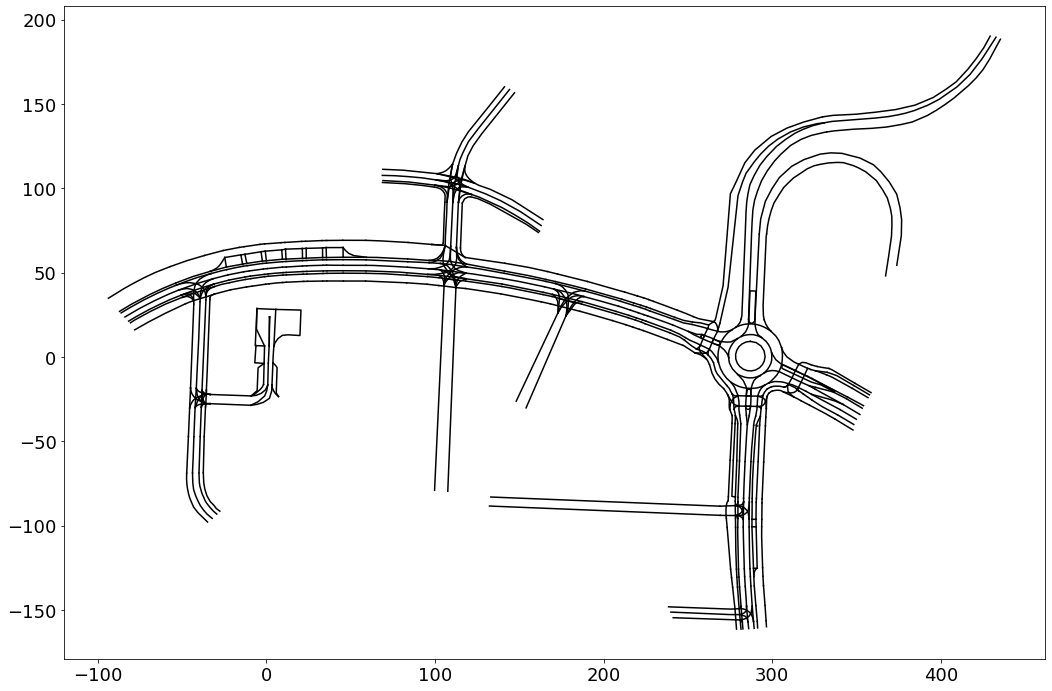

In [5]:
plt.rcParams['figure.figsize'] = (24, 12)
font = {'size'   : 18}
plt.rc('font', **font)
plt.gca().set_aspect('equal', 'box')

### START CODE HERE ###
ll_map = lanelet2.io.load("maps/acdc_campus_aachen.osm", projector)
plot_map(ll_map)
### END CODE HERE ###

# Task: Defining Start- and End-Position

Now that we have loaded the map, we can define the start- and target position for the route. As the vehicles internal GPS sensor provides the position in the WGS84 system we should implement a function to transform the start- and target position in the map coordinate system. Therefore we will use the `UTMProjector` initialized before. The projector class offers a function `UtmProjector.forward` to transform a WGS84-Position into the map-frame. The function expects the projector-object and a `GPSPoint`-object. You can initialize a `GPSPoint` by passing the `latitude`, `longitude` and `altitude` to the constructor. The function will return an position as `BasicPoint3d`. For an exemplary point `p` you can access the coordinates by typing `p.x`,`p.y` and `p.z`.

__Hint:__ As we are only planning a route in 2D you can set the value for the `altitude` to 0 by default! 

In [6]:
def latlon2mapframe(proj, pos_lat, pos_lon):
    """
    Function that projects a given lat-lon-position to utm coordinates 
    Arguments:
    proj -- Lanelet2 utm-projector object
    pos_lat -- latitude-coordinate of a given position
    pos_lon -- longitude-coordinate of a given position
    
    Returns:
    pos_out -- utm-position given as BasicPoint3d
    """
    ### START CODE HERE ###
    pos_in = GPSPoint(pos_lat,pos_lon,0.0)
    pos_out = UtmProjector.forward(proj, pos_in)
    ### END CODE HERE ###
    return pos_out

Now we can define a start and an end position, transfer these positions to the map frame and visualize them on the map. To transfer the points use the function defined above. You can define the start and end position by yourself. Therfore you may use online tools e.g. [latlong](https://www.latlong.net/) or [GoogleMaps](https://www.google.de/maps/) to select the coordinates within the area of the map.

Some exemplary coordinates could be the entry of the roundabout (`latitude=50.787392`, `longitude=6.050978`) and the ika parking lot (`latitude=50.787337`, `longitude=6.046488`).

In [7]:
### START CODE HERE ###
start_lat = 50.787392
start_lon = 6.050978
end_lat = 50.787337
end_lon = 6.046488
map_start = latlon2mapframe(projector, start_lat, start_lon)
map_end = latlon2mapframe(projector, end_lat, end_lon)
### END CODE HERE ###

To visualize your projected positions on the map, just plot the map (using `plot_map(...)`) and replace the `[]`'s of the following code-block with the `x` and `y`-coordinates of the resulting start and end position. The start position will be represented by a red dot, while the end position is visualized as green dot!

__Hint:__ The function `latlon2mapframe` will return an position as `BasicPoint3d`. For an exemplary point `p` you can access the coordinates by typing `p.x`,`p.y` and `p.z`.

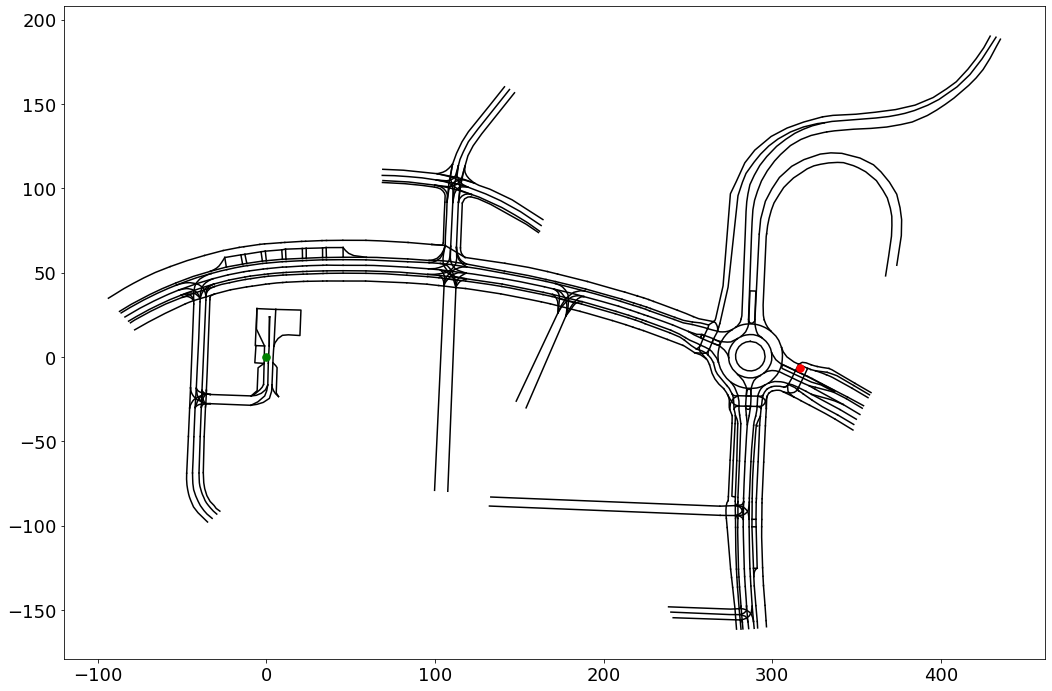

In [8]:
plt.gca().set_aspect('equal', 'box')

### START CODE HERE ###
#Visualize Map --> plot_map(...)
plot_map(ll_map)
### END CODE HERE ###

#Visualize Start Position
def plot_start_position(start_pos):
    """
    Function that visualizes a given start-position as green marker
    Arguments:
    start_pos -- utm-coordinates of the start-position
    
    Returns:
    None
    """
### START CODE HERE ###
    plt.plot(start_pos.x, start_pos.y,'.r',markersize=15)
### END CODE HERE ###

#Visualize End Position
def plot_end_position(end_pos):
    """
    Function that visualizes a given end-position as red marker
    Arguments:
    end_pos -- utm-coordinates of the end-position
    
    Returns:
    None
    """
### START CODE HERE ###
    plt.plot(end_pos.x, end_pos.y,'.g',markersize=15)
### END CODE HERE ###

plot_start_position(map_start)
plot_end_position(map_end)

# Task: Initializing the RoutingGraph

Now that we have defined start and end position sucesfully, we are prepared to plan a route from a given start position to a desired destination. As you've already learned the problem of route planning can be solved with graph-search algorithms like e.g. the Dijkstra-Algorithm used by the Lanelet2 framework. To perform a graph-search we need a graph representation of the map. Within the Lanelet2 framework the graph is described as __routing-graph__.

The routing-graph can be constructed using the function `lanelet2.routing.RoutingGraph`. This function expects the lanelet2-map-object and a traffic-rules-object. The need of traffic rules to create the routing graph depends on the fact that e.g. a pedestrian is allowed to walk on the pavement while a car is allowed to drive on the road only. Therfore it should get clear, that the routing graph differs for different traffic participants.

To generate the traffic-rules you can call the function `lanelet2.traffic_rules.create`. This function expects the nomination of the location and the participant for who the rules should be generated. In this case you should use `lanelet2.traffic_rules.Locations.Germany` as first and `lanelet2.traffic_rules.Participants.Vehicle` as second argument.

In [9]:
### START CODE HERE ###
trafficRules = lanelet2.traffic_rules.create(lanelet2.traffic_rules.Locations.Germany, lanelet2.traffic_rules.Participants.Vehicle)
routingGraph = lanelet2.routing.RoutingGraph(ll_map, trafficRules)
### END CODE HERE ###

# Task: Planning a Route

To plan a route the routing graph object offers the function `getRoute`. This function expects a start- and an end-lanelet as input. For this reason we need to identify the nearest lanelets to the previously defined start and end position.

Therefore we want to define the function `find_nearest_lanelet` which expects the map object and a position given as `BasicPoint3d` (output of `latlon2mapframe`). The resulting function should return the `lanelet`-object nearest to the input position. To that you can use the function `lanelet2.geometry.findWithin3d`. This function can be applied to several layers of the lanelet-map. As already mentioned the lanelet map is composed from different primitives (e.g. `point`->`linestring`->`lanelet`). You can access the different layers of a lanelet map by typing `map.<LayerType>`. 

In this case we want to find the nearest lanelet. Therfore we should pass the `laneletLayer` to the function. Next to the layer, the function `lanelet2.geometry.findWithin3d` expects the position where we would like to find lanelets (as `BasicPoint3d`) and a search radius (e.g. `5.0` m). If some lanelets are found at the given position within the defined search radius, the function will return a list containing a pair `<distance, lanelet>`. The list is sorted with rising distance of the lanelet from defined position. Therefore you can access the nearest lanelet-object by typing `lanelets[0][1]`. Consider the possibility that no lanelet could be found. In this case `lanelet2.geometry.findWithin3d` will return an empty list. Thats why you should check the length of the list (e.g. `len(a_list)`) with an if-query. Moreover the function `lanelet2.geometry.findWithin3d` could return a lanelet which is not driveable by a vehicle (e.g. a walkway). Therefore you should check if the vehicle could pass the given lanelet. There to the traffic rules object offers a function `canPass(...)` which expects a lanelet object as an input. If the given lanelet can be used by the participant defined in the traffic rules, this function will return `True`. To avoid returning a lanelet which cannot be passed by the vehicle, include a check to only return the nearest lanelet, which can be utilized by the vehicle.

In [10]:
def find_nearest_lanelet(ll_map, pos, rules):
    """
    Function that returns the lanelet-object nearest to the input position
    Arguments:
    ll_map -- Lanelet2 map-object
    pos -- `BasicPoint3d` position where lanelet objects shall be found
    rules -- Lanelet2 traffic-rules object
    
    Returns:
    ll -- lanelet-object nearest to the given input position
    """
    ### START CODE HERE ###
    lanelets=lanelet2.geometry.findWithin3d(ll_map.laneletLayer, pos, 5.0)
    if(len(lanelets)>0):
        print("Lanelets found at given map-position!")
        for ll in lanelets:
            if(rules.canPass(ll[1])):
                return ll[1]
        print("No Lanelet found which can be used by a vehicle!")
        return
    ### END CODE HERE ###
    else:
        print("No Lanelets found at given map-position!")
        return

Now that you have implemented the function `find_nearest_lanelet` you can use it to determine the start- and the end-lanelet for the route-planning process. You may print the `ID` of the resulting lanelets. You can access the ID of an lanelet-object by typing `ll_object.id`.

In [15]:
lat = 50.787845
lon = 6.046807
map_ans= latlon2mapframe(projector, lat, lon)

In [11]:
### START CODE HERE ###
start_lanelet = find_nearest_lanelet(ll_map, map_start, trafficRules)
print("ID of Start-Lanelet: ", start_lanelet.id)
end_lanelet = find_nearest_lanelet(ll_map, map_end, trafficRules)
print("ID of End-Lanelet: ", end_lanelet.id)
### END CODE HERE ###

Lanelets found at given map-position!
ID of Start-Lanelet:  10489
Lanelets found at given map-position!
ID of End-Lanelet:  10156


In [16]:
start_lanelet = find_nearest_lanelet(ll_map, map_ans, trafficRules)
print("ID of Start-Lanelet: ", start_lanelet.id)

Lanelets found at given map-position!
ID of Start-Lanelet:  10618


With the start- and end-lanelet of the route we are able to plan it. We already mentioned, that the `routingGraph`-Object offers the function `getRoute`. You should pass the start- and end-lanelet-object to the function. If the end-lanelet is reachable within the given map, the function will return an route object. From this route object we need to derive the shortest path. The following figure emphasizes the difference between a route and the shortest path.

![](https://raw.githubusercontent.com/fzi-forschungszentrum-informatik/Lanelet2/master/lanelet2_routing/doc/images/shortest_path_and_route.png)

Image: [github.com/fzi-forschungszentrum-informatik/Lanelet2](https://github.com/fzi-forschungszentrum-informatik/Lanelet2/blob/master/lanelet2_routing/doc/images/shortest_path_and_route.png)

Especially for roads with multiple lanes (e.g. highways) the difference gets clear:

While the route contains all lanelets reaching from the start to the end position (without choosing a completly different road), the shortest path only consists the lanelets which lead the vehicle to the target position respecting the minimization of a specified cost function.

To access the shortest path, the route-object offerst the function `shortestPath` which returns the shortest-path-object.

Within the following code-block you should call the function `getRoute` and check if the route is valid (if no route is possible `getRoute` will return `None`; use an `if-else`-query here). Afterwards you can call the function `shortestPath`. This function will return a list of lanelet-objects. Iterate over this list (`for a in b`) and print the ID's of all lanelets consecuting the shortest path.

In [12]:
### START CODE HERE ###
route = routingGraph.getRoute(start_lanelet, end_lanelet)

if (route is not None):
    ll_path = route.shortestPath()
    print("Lanelets (IDs) consecuting the shortest path:")
    for ll in ll_path:
        print(ll.id)
### END CODE HERE ###
else:
    print("Route planning is not possible!")

Lanelets (IDs) consecuting the shortest path:
10489
10343
10339
11903
11905
11906
10440
10451
10457
10498
10507
10513
10519
10525
10531
10537
10547
10553
10559
10565
10571
10577
10596
10601
10607
10612
10618
10631
10624
10634
10640
10645
10651
10669
10675
10681
10685
10691
10693
11923
10230
10225
10162
10159
10160
10161
9968
10155
10156


# Task: Processing and Visualizing the Route

As mentioned in the theory-videos, the result of the algorithms on Navigation-Level (e.g. the route) may be used as reference for the algorithms on Guidance- and Stabilization-Level. Therfore we need to derive a path from the sequence of lanelets using the function `lanelets2path`. This function expects the `shortestPath` determined before.

We want to return two lists containing the x- and y-coordinates of the path. The path usually describes the centerline of the road. Therfore we need to extract the centerline of each lanelet. There to you can access the centerline by typing `ll.centerline` which returns a list of points with x- and y-coordinates.

In the following function first iterate over all lanelets in the shortest path. For each lanelet determine the point-list describing the centerline of the lanelet. Then you need to iterate over this point list to derive the x- and y-coordinates of each waypoint `p`. Add these coordinates to the lists `x` and `y` using `x.append(p.x)` i.e. `y.append(p.y)`. 

In [13]:
def lanelets2path(lanelet_path):
    """
    Function that derives a x-y-path from a given lanelet-sequence
    Arguments:
    lanelet_path -- list of lanelet objects consecuting the shortest path
    
    Returns:
    x -- list of x-coordinates of the resulting path
    y -- list of y-coordinates of the resulting path
    """
    x=[]
    y=[]
### START CODE HERE ###
    for ll in lanelet_path:
        cl = ll.centerline
        for p in cl:
            x.append(p.x)
            y.append(p.y)
### END CODE HERE ###
    return x, y

Now that you have defined the function `lanelets2path` you can call this function. The following code-block will moreover visualize the map, the start- and end-position and the resulting path!

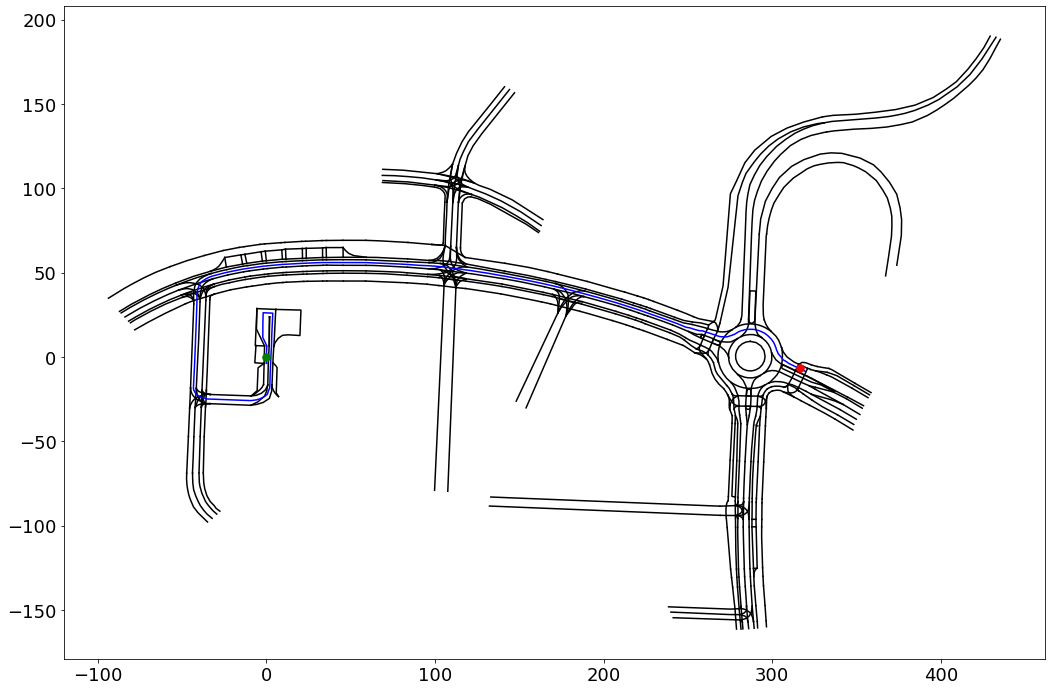

In [14]:
plt.gca().set_aspect('equal', 'box')

### START CODE HERE ###
#Calculate Map Path
path=lanelets2path(ll_path)

#Visualize Map --> plot_map(...)
plot_map(ll_map)
### END CODE HERE ###

#Visualize Path
plt.plot(path[0],path[1],'b')
#Visualize Start Position
plot_start_position(map_start)
#Visualize End Position
plot_end_position(map_end)

Congratulations! You finished the Assignment `Route-Planning`!

Feel free to play around with the implemented tool e.g. vary the start and end position (with help of e.g. [latlong](https://www.latlong.net/) or [GoogleMaps](https://www.google.de/maps/))!

__Hint:__ Don't close this jupyter notebook, you may need it to answer the questions in the __edX-Quiz__ regarding this assignment!

# Wrap Up
- You learned how to load a road network,
- how to use projections from WGS84 to UTM coordinates,
- how to initialize a routing-graph,
- you got to know the difference between the route and shortest path and
- you learned how to plan and post-process a route...

...using the lanelet2 framework!

## References

#### Lanelet2

## License

MIT License

Copyright 2022 Institute for Automotive Engineering of RWTH Aachen University.